In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, to_onehot, CustomDataset
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 200
batch_size = 250

train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)

cuda:0


In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        out = self.model(x)
        return out

In [6]:
class Classifier():
    def __init__(self, train_loader, valid_loader, test_loader):
        self.net = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.ReLU(), flatten=True, device=device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.loss = 0.0
        self.loss_log = []
        self.acc_log = []
        
    def show_data_sample(self):
        with torch.no_grad():
            data, label = next(iter(train_loader))
            plot_data = data.cpu().data[:50].numpy().reshape(-1, 1, 28, 28)
            plot_mnist(plot_data, (5, 10))
            print ("Checking labels: {} \n\n".format(label[:50]))
        
    def train(self, epoch):
        train_size = len(self.train_loader.sampler)          
        for batch_idx, (data, label) in enumerate(self.train_loader):
            label = label.to(device)
            
            # train
            self.optimizer.zero_grad()              
            output = self.net(data)       
            self.loss = self.criterion(output, label)

            self.loss.backward()
            self.optimizer.step()

            if batch_idx % 100 == 0:
                line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                    epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(self.train_loader))
                losses = '{:.4f}'.format(self.loss.item())
                print(line + losses)

        else:
            batch_idx += 1
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(self.train_loader))
            losses = '{:.4f}'.format(self.loss.item())
            print(line + losses)            
        
    def validation(self, epoch):
        val_size = len(self.valid_loader)
        loss = 0.
        total = 0
        correct = 0        
        with torch.no_grad():
            for data, label in self.valid_loader:
                label = label.to(device)
                output = self.net(data)
                loss += self.criterion(output, label)

                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

            loss /= val_size       
            
        accuracy = 100 * correct / total

        report = 'Valid loss: {:.4f} Accuracy: {:.2f} \n'.format(loss, accuracy)
        print(report)    
        
        self.loss_log.append(loss.item())
        self.acc_log.append(accuracy)

    def start_training(self, train_epoch):
        for epoch in range(1, train_epoch + 1):
            self.net.train()
            self.train(epoch)
            self.net.eval()   
            self.validation(epoch)
            
    def test(self):
        test_size = len(self.test_loader)
        loss = 0.
        total = 0
        correct = 0        
        with torch.no_grad():
            for data, label in self.test_loader:
                label = label.to(device)
                output = self.net(data)
                loss += self.criterion(output, label)

                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

            loss /= test_size       
            
        accuracy = 100 * correct / total

        report = 'Test loss: {:.4f} Accuracy: {:.2f} \n'.format(loss, accuracy)
        print(report)    
     


### Классификатор на исходных данных

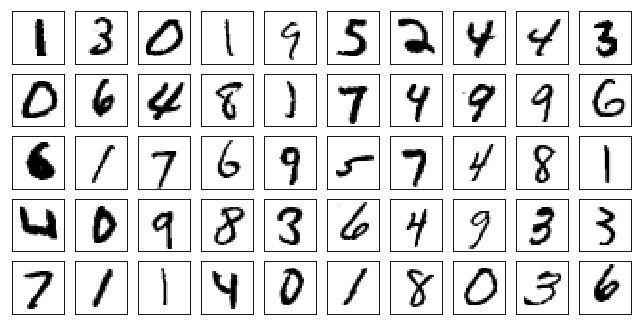

Checking labels: tensor([1, 3, 0, 1, 9, 5, 2, 4, 4, 3, 0, 6, 4, 8, 1, 7, 4, 9, 9, 6, 6, 1, 7, 6,
        9, 5, 7, 4, 8, 1, 4, 0, 9, 8, 3, 6, 4, 9, 3, 3, 7, 1, 1, 4, 0, 1, 8, 0,
        3, 6]) 


Train Epoch: 1 [0/50000 (0%)]	Losses 2.3056
Train Epoch: 1 [25000/50000 (50%)]	Losses 0.3449
Train Epoch: 1 [50000/50000 (100%)]	Losses 0.3247
Valid loss: 0.3511 Accuracy: 90.02 

Train Epoch: 2 [0/50000 (0%)]	Losses 0.3620
Train Epoch: 2 [25000/50000 (50%)]	Losses 0.3134
Train Epoch: 2 [50000/50000 (100%)]	Losses 0.2134
Valid loss: 0.2628 Accuracy: 92.56 

Train Epoch: 3 [0/50000 (0%)]	Losses 0.3052
Train Epoch: 3 [25000/50000 (50%)]	Losses 0.2830
Train Epoch: 3 [50000/50000 (100%)]	Losses 0.1769
Valid loss: 0.2241 Accuracy: 93.70 

Train Epoch: 4 [0/50000 (0%)]	Losses 0.2809
Train Epoch: 4 [25000/50000 (50%)]	Losses 0.1781
Train Epoch: 4 [50000/50000 (100%)]	Losses 0.2026
Valid loss: 0.1979 Accuracy: 94.27 

Train Epoch: 5 [0/50000 (0%)]	Losses 0.1481
Train Epoch: 5 [25000/50000 (50%)]	Losses

In [7]:
cls_raw = Classifier(train_loader, valid_loader, test_loader)
cls_raw.show_data_sample()
cls_raw.start_training(10)

In [8]:
cls_raw.test()

Test loss: 0.0892 Accuracy: 97.21 



### Классификатор на данных AAE_C

In [9]:
aae_c_train = CustomDataset('./aae_c_train_data')
aae_c_valid = CustomDataset('./aae_c_valid_data')
aae_c_test = CustomDataset('./aae_c_test_data')

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

aae_c_train_indices = list(range(aae_c_train.data.shape[0]))
aae_c_valid_indices = list(range(aae_c_valid.data.shape[0]))
aae_c_test_indices = list(range(aae_c_test.data.shape[0]))

aae_c_train_loader = DataLoader(aae_c_train, batch_size=batch_size, sampler=SubsetRandomSampler(aae_c_train_indices))
aae_c_valid_loader = DataLoader(aae_c_valid, batch_size=batch_size, sampler=SubsetRandomSampler(aae_c_valid_indices))
aae_c_test_loader = DataLoader(aae_c_test, batch_size=batch_size, sampler=SubsetRandomSampler(aae_c_test_indices))

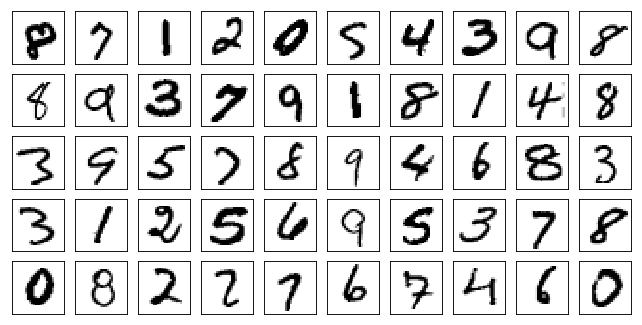

Checking labels: tensor([8, 7, 1, 2, 0, 5, 4, 3, 9, 8, 8, 9, 3, 7, 9, 1, 8, 1, 4, 8, 3, 9, 5, 7,
        8, 9, 4, 6, 8, 3, 3, 1, 2, 5, 6, 9, 5, 3, 7, 8, 0, 8, 2, 2, 7, 6, 7, 4,
        6, 0]) 


Train Epoch: 1 [0/50000 (0%)]	Losses 2.3087
Train Epoch: 1 [25000/50000 (50%)]	Losses 1.1006
Train Epoch: 1 [50000/50000 (100%)]	Losses 0.8568
Valid loss: 0.8408 Accuracy: 73.88 

Train Epoch: 2 [0/50000 (0%)]	Losses 0.7840
Train Epoch: 2 [25000/50000 (50%)]	Losses 0.8091
Train Epoch: 2 [50000/50000 (100%)]	Losses 0.6021
Valid loss: 0.6283 Accuracy: 80.46 

Train Epoch: 3 [0/50000 (0%)]	Losses 0.6174
Train Epoch: 3 [25000/50000 (50%)]	Losses 0.6746
Train Epoch: 3 [50000/50000 (100%)]	Losses 0.3981
Valid loss: 0.4604 Accuracy: 85.70 

Train Epoch: 4 [0/50000 (0%)]	Losses 0.4959
Train Epoch: 4 [25000/50000 (50%)]	Losses 0.3884
Train Epoch: 4 [50000/50000 (100%)]	Losses 0.3545
Valid loss: 0.3702 Accuracy: 88.72 

Train Epoch: 5 [0/50000 (0%)]	Losses 0.2909
Train Epoch: 5 [25000/50000 (50%)]	Losses

In [11]:
cls_aae_c = Classifier(aae_c_train_loader, aae_c_valid_loader, aae_c_test_loader)
cls_aae_c.show_data_sample()
cls_aae_c.start_training(10)

In [12]:
cls_aae_c.test()

Test loss: 0.1490 Accuracy: 95.28 



### Классификатор на данных CAAE

In [13]:
caae_train = CustomDataset('./caae_train_data')
caae_valid = CustomDataset('./caae_valid_data')
caae_test = CustomDataset('./caae_test_data')

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

caae_train_indices = list(range(caae_train.data.shape[0]))
caae_valid_indices = list(range(caae_valid.data.shape[0]))
caae_test_indices = list(range(caae_test.data.shape[0]))

caae_train_loader = DataLoader(caae_train, batch_size=batch_size, sampler=SubsetRandomSampler(caae_train_indices))
caae_valid_loader = DataLoader(caae_valid, batch_size=batch_size, sampler=SubsetRandomSampler(caae_valid_indices))
caae_test_loader = DataLoader(caae_test, batch_size=batch_size, sampler=SubsetRandomSampler(caae_test_indices))

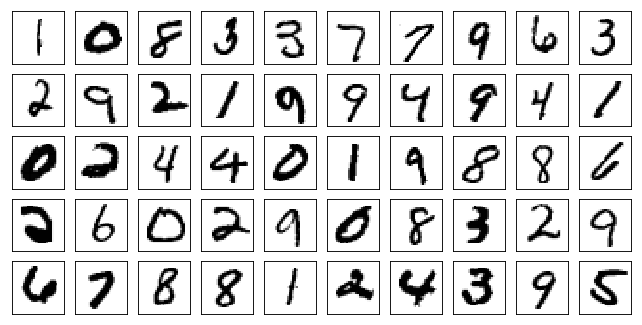

Checking labels: tensor([1, 0, 8, 3, 3, 7, 7, 9, 6, 3, 2, 9, 2, 1, 9, 9, 4, 9, 4, 1, 0, 2, 4, 4,
        0, 1, 9, 8, 8, 6, 2, 6, 0, 2, 9, 0, 8, 3, 2, 9, 6, 7, 8, 8, 1, 2, 4, 3,
        9, 5]) 


Train Epoch: 1 [0/50000 (0%)]	Losses 2.3165
Train Epoch: 1 [25000/50000 (50%)]	Losses 0.3752
Train Epoch: 1 [50000/50000 (100%)]	Losses 0.2521
Valid loss: 0.2794 Accuracy: 91.99 

Train Epoch: 2 [0/50000 (0%)]	Losses 0.2832
Train Epoch: 2 [25000/50000 (50%)]	Losses 0.2580
Train Epoch: 2 [50000/50000 (100%)]	Losses 0.2285
Valid loss: 0.2013 Accuracy: 94.04 

Train Epoch: 3 [0/50000 (0%)]	Losses 0.1955
Train Epoch: 3 [25000/50000 (50%)]	Losses 0.1772
Train Epoch: 3 [50000/50000 (100%)]	Losses 0.1003
Valid loss: 0.1578 Accuracy: 95.21 

Train Epoch: 4 [0/50000 (0%)]	Losses 0.1544
Train Epoch: 4 [25000/50000 (50%)]	Losses 0.2353
Train Epoch: 4 [50000/50000 (100%)]	Losses 0.1597
Valid loss: 0.1294 Accuracy: 96.15 

Train Epoch: 5 [0/50000 (0%)]	Losses 0.1364
Train Epoch: 5 [25000/50000 (50%)]	Losses

In [15]:
cls_caae = Classifier(caae_train_loader, caae_valid_loader, caae_test_loader)
cls_caae.show_data_sample()
cls_caae.start_training(10)

In [16]:
cls_caae.test()

Test loss: 0.0648 Accuracy: 98.05 



### Сравнение классификаторов

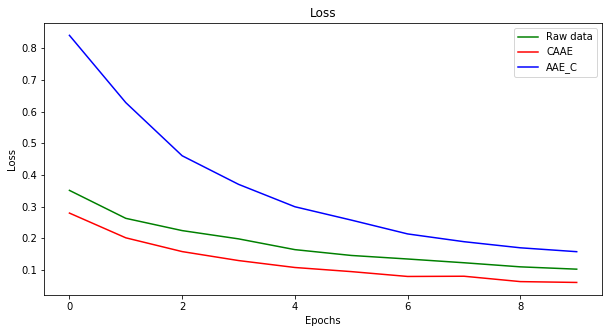

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Loss")
plt.plot(cls_raw.loss_log, color='green', label='Raw data')
plt.plot(cls_caae.loss_log, color='red', label='CAAE')
plt.plot(cls_aae_c.loss_log, color='blue', label='AAE_C')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.legend()

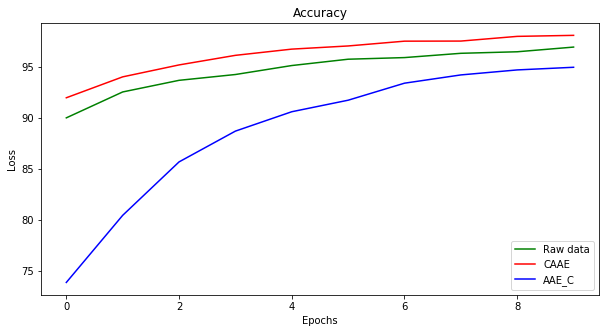

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Accuracy")
plt.plot(cls_raw.acc_log, color='green', label='Raw data')
plt.plot(cls_caae.acc_log, color='red', label='CAAE')
plt.plot(cls_aae_c.acc_log, color='blue', label='AAE_C')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.legend()